In [20]:
# Header for the notebook
from datetime import datetime
from IPython.display import display, Markdown

# Get the current date
title = "Coding Project Notebook - Circular Task"
current_date = datetime.now().strftime("%d %B %Y, %H:%M:%S")
authors = "Victor Salvat and Jin Wei Zhang (and Copilot)"

# Insert the date into the notebook
display(Markdown(f"# {title}"))
display(Markdown(f"{current_date}"))
display(Markdown(f"by {authors}"))

# Coding Project Notebook - Circular Task

24 November 2025, 15:01:52

by Victor Salvat and Jin Wei Zhang (and Copilot)

Introduction



## Table of Contents
<a id="total-title"></a>
- [1. Recreate figures and plots (visual reproduction)](#1-title)
- [2. Reproduce marker measurements (data verification)](#2-title)
- [3. Generate and analyze circular task data](#3-title)
- [4. Discussion, limitations, and conclusions](#4-title)

---
<a id="1-title"></a>
# 1. Recreate figures and plots (visual reproduction)

In [21]:
import csv

# Path to your CSV file
file_path = "data/001MoDe_R1.marker.csv"

# Open and read the CSV
with open(file_path, mode="r", newline="", encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)

    # Print each row
    for row in reader:
        print(row)

['screenWidth 1104;screenHeight 661;cornerX 302;cornerY 80;centerX 552;centerY 330;externalRadius 250;internalRadius 170;borderRadius 1;cursorRadius 16;indexOfDifficulty 28.00696429476858;taskRadius 209.5;taskTolerance 47;borderColor java.awt.Color[r=255', 'g=255', 'b=255];backgroundColor java.awt.Color[r=0', 'g=0', 'b=0];cursorColorRecord java.awt.Color[r=255', 'g=0', 'b=0];cursorColorWait java.awt.Color[r=255', 'g=255', 'b=0];autoStart 3600;cycleMaxNumber 6;cycleDuration 20;software LSL-mouse;version 1.2.0rc5;task CircularTarget;isWithLSL false']
['2021-03-26 17:38:25.650']
[]
['2021-03-26 17:38:32.325', '1616776712325', 'KeyTyped=32 DoCycleChange']
['2021-03-26 17:38:32.331', '1616776712331', 'DoCycleChange:DoStartCycleTimedSequence']
['2021-03-26 17:38:32.333', '1616776712333', 'DoCycleChange:DoRecord RecordDone=0 PauseDone=0 ToDo=6']
['2021-03-26 17:38:52.336', '1616776732336', 'DoCycleChange:DoPause RecordDone=1 PauseDone=0 ToDo=6']
['2021-03-26 17:39:12.340', '1616776752340', 'D

=== LOADING MARKERS ===
Loaded 25 marker rows

=== METADATA ===
screenWidth 1104;screenHeight 661;cornerX 302;cornerY 80;centerX 552;centerY 330;externalRadius 250;internalRadius 170;borderRadius 1;cursorRadius 16;indexOfDifficulty 28.00696429476858;taskRadius 209.5;taskTolerance 47;borderColor java.awt.Color[r = 255
g                    = 255
b                    = 0];autoStart 3600;cycleMaxNumber 6;cycleDuration 20;software LSL-mouse;version 1.2.0rc5;task CircularTarget;isWithLSL false

=== CYCLES DETECTED ===
Cycle 1: 1616776712333  →  1616776732336   (20.00s)
Cycle 2: 1616776752340  →  1616776772351   (20.01s)
Cycle 3: 1616776792372  →  1616776812386   (20.01s)
Cycle 4: 1616776832390  →  1616776852404   (20.01s)
Cycle 5: 1616776872419  →  1616776892433   (20.01s)

=== TASK GEOMETRY ===
Screen: 1902 x 973
Center: 951.0 486.5
Radii → Inner: 326 Outer: 406 Task: 365.5

=== LOADING MOUSE DATA ===
Mouse samples: (19593, 4) rows

=== RECORD 1 ===


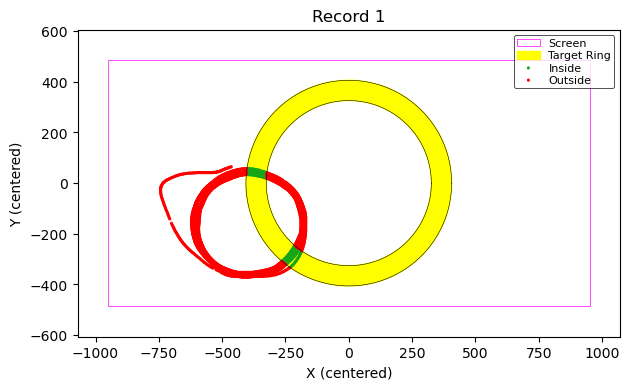

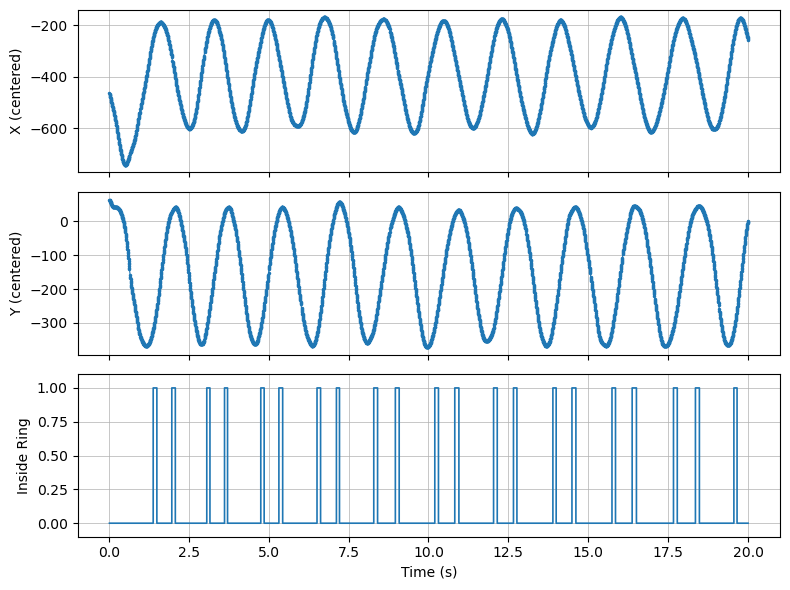


=== RECORD 2 ===


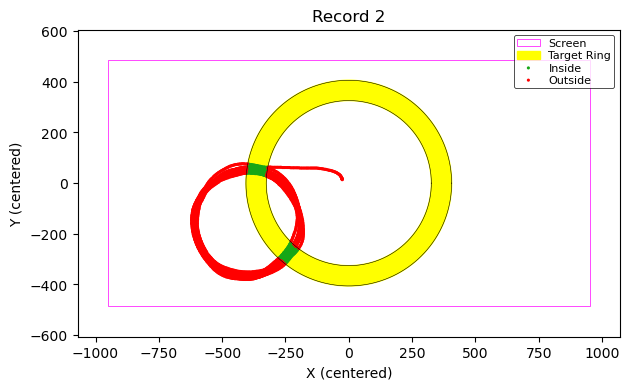

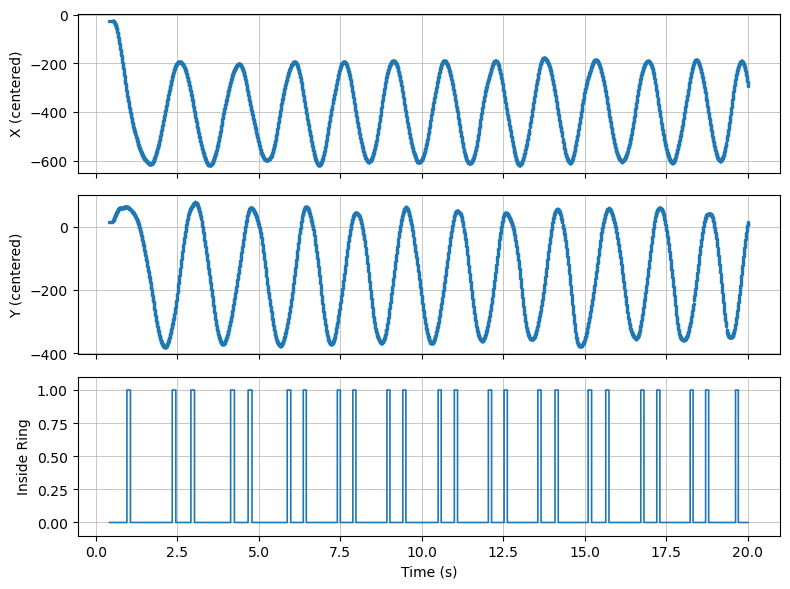


=== RECORD 3 ===


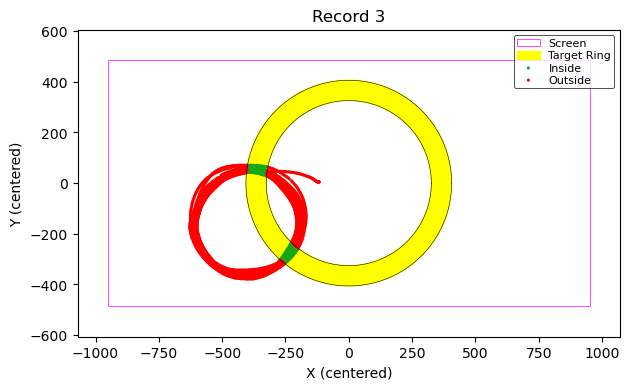

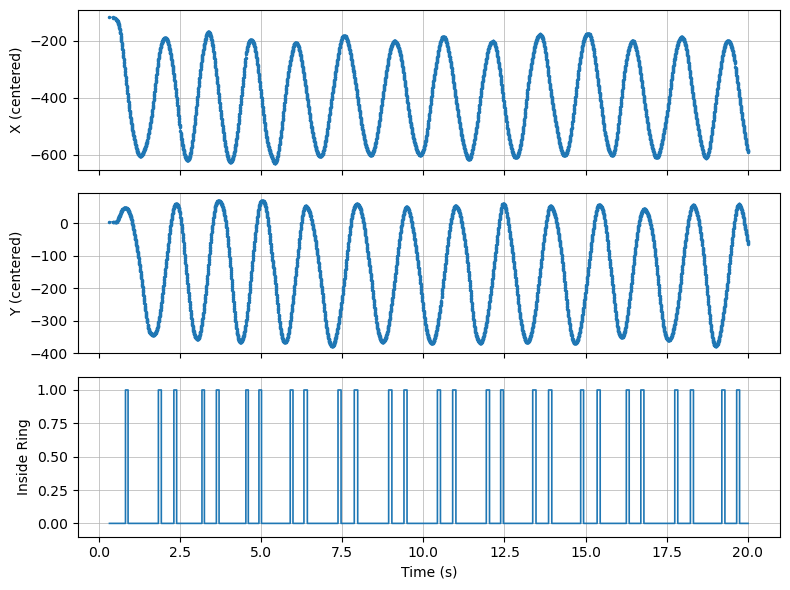


=== RECORD 4 ===


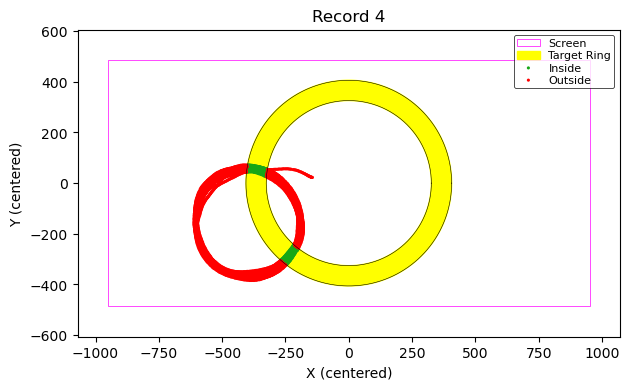

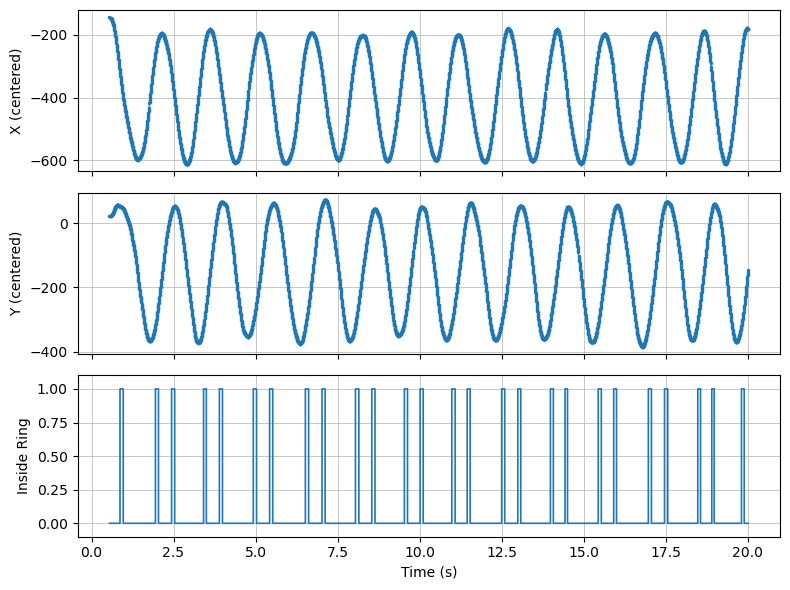


=== RECORD 5 ===


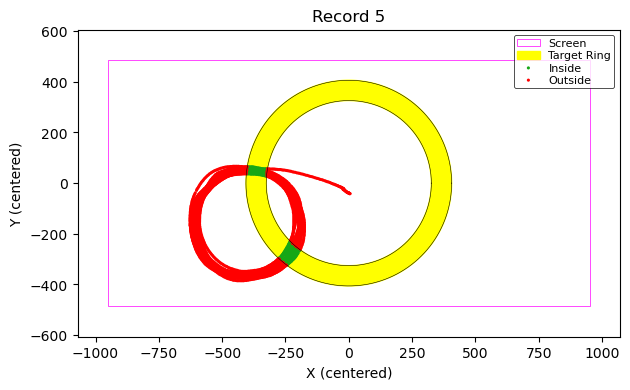

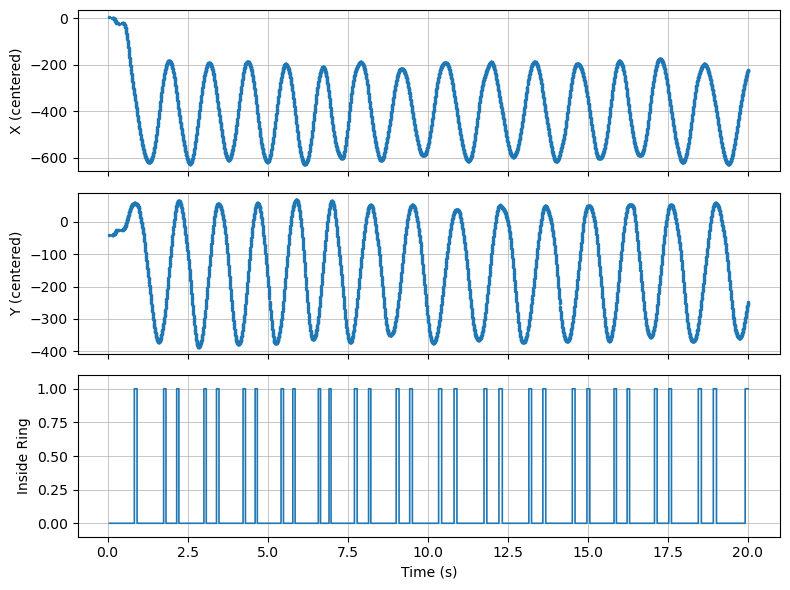

In [27]:
# =====================================================================
# SECTION 1 — MARKER FILE  →  METADATA  →  CYCLE TIMES
# =====================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

print("=== LOADING MARKERS ===")

markers_raw = []

with open("data/001MoDe_R1.marker.csv", "r") as f:
    for line in f:
        L = line.strip()
        if not L:
            continue

        # Header (semicolon fields)
        if ";" in L and "," not in L:
            markers_raw.append(L.split(";"))
            continue

        # Timestamped events (comma-separated)
        if "," in L:
            markers_raw.append([p.strip() for p in L.split(",")])
            continue

        # Summary rows (space-separated)
        markers_raw.append(L.split())

print("Loaded", len(markers_raw), "marker rows")



# =====================================================================
# EXTRACT METADATA
# =====================================================================
header_line = markers_raw[0]
metadata = {}

for p in header_line:
    if "=" in p:
        k, v = p.split("=", 1)
        v = v.replace("java.awt.Color", "")
        metadata[k.strip()] = v.strip()

def auto(v):
    try:
        return float(v) if "." in v else int(v)
    except:
        return v

metadata_clean = {k: auto(v) for k, v in metadata.items()}

print("\n=== METADATA ===")
for k, v in metadata_clean.items():
    print(f"{k:20s} = {v}")



# =====================================================================
# EXTRACT CYCLE START/STOP
# =====================================================================
starts, stops = [], []

for row in markers_raw:
    if len(row) < 3:
        continue

    ts = row[1]
    event = row[2]

    if not ts.isdigit():
        continue

    t = int(ts)

    if "DoRecord" in event:
        starts.append(t)
    if "DoPause" in event:
        stops.append(t)

cycles = list(zip(starts, stops))

print("\n=== CYCLES DETECTED ===")
for i, (s, e) in enumerate(cycles):
    print(f"Cycle {i+1}: {s}  →  {e}   ({(e-s)/1000:.2f}s)")



# =====================================================================
# EXTRACT SCREEN + TASK PARAMETERS
# =====================================================================
screen_w = metadata_clean.get("screenWidth", 1902)
screen_h = metadata_clean.get("screenHeight", 973)
centerX  = metadata_clean.get("centerX", screen_w/2)
centerY  = metadata_clean.get("centerY", screen_h/2)

R_out  = metadata_clean.get("externalRadius", 406)
R_in   = metadata_clean.get("internalRadius", 326)
R_task = metadata_clean.get("taskRadius", 365.5)

print("\n=== TASK GEOMETRY ===")
print("Screen:", screen_w, "x", screen_h)
print("Center:", centerX, centerY)
print("Radii → Inner:", R_in, "Outer:", R_out, "Task:", R_task)



# =====================================================================
# SECTION 2 — LOAD MOUSE DATA
# =====================================================================
print("\n=== LOADING MOUSE DATA ===")

df = pd.read_csv("data/001MoDe_R1.csv", skiprows=4, header=None)
df = df.astype(float)
df.columns = ["timestamp", "x", "y", "inTarget"]

print("Mouse samples:", df.shape, "rows")

# Normalize timestamps
T0 = int(df["timestamp"].iloc[0])
df["t"] = (df["timestamp"] - T0) / 1000.0



# =====================================================================
# SECTION 3 — GEOMETRY (RINGS)
# =====================================================================
theta = np.linspace(0, 2*np.pi, 600)
x_outer = R_out * np.cos(theta)
y_outer = R_out * np.sin(theta)
x_inner = R_in  * np.cos(theta)
y_inner = R_in  * np.sin(theta)

xs_ring = np.concatenate([x_outer, x_inner[::-1]])
ys_ring = np.concatenate([y_outer, y_inner[::-1]])



# =====================================================================
# SECTION 4 — SPLIT DATASET INTO CYCLES
# =====================================================================
cycle_dfs = []
for (start, end) in cycles:
    d = df[(df.timestamp >= start) & (df.timestamp <= end)].copy()
    d["t_cycle"] = (d["timestamp"] - start) / 1000.0
    cycle_dfs.append(d)



# =====================================================================
# SECTION 5 — PLOT ALL RECORDS
# =====================================================================
for i, d in enumerate(cycle_dfs):

    print(f"\n=== RECORD {i+1} ===")

    # ----------------------------------------
    # CIRCULAR TRAJECTORY
    # ----------------------------------------
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()

    # SCREEN rectangle
    screen_rect = patches.Rectangle(
        (-centerX, -centerY),
        screen_w,
        screen_h,
        linewidth=0.5,
        edgecolor="magenta",
        facecolor="none",
        label="Screen")
    ax.add_patch(screen_rect)

    # Yellow ring
    ax.fill(xs_ring, ys_ring, color="#FFFF00", alpha=1.0, label="Target Ring")
    ax.plot(x_outer, y_outer, color="black", linewidth=0.4)
    ax.plot(x_inner, y_inner, color="black", linewidth=0.4)

    # Mouse trajectory
    x = d["x"].values - centerX
    y = d["y"].values - centerY
    r = np.hypot(x, y)
    inside = (r >= R_in) & (r <= R_out)

    ax.scatter(x[inside],  y[inside],  s=5, c="#16A716", edgecolors="none", label="Inside")
    ax.scatter(x[~inside], y[~inside], s=5, c="#FF0000", edgecolors="none", label="Outside")

    pad = 120
    ax.set_xlim(-centerX - pad, centerX + pad)
    ax.set_ylim(-centerY - pad, centerY + pad)
    ax.set_aspect("equal")

    plt.title(f"Record {i+1}")
    plt.xlabel("X (centered)")
    plt.ylabel("Y (centered)")

    leg = ax.legend(loc="upper right", fontsize=8, frameon=True, fancybox=True,
                    borderpad=0.3, labelspacing=0.2)
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(0.6)

    plt.show()


    # ----------------------------------------
    # TIME SERIES
    # ----------------------------------------
    fig_ts, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

    axs[0].plot(d["t_cycle"], x, marker='.', markersize=3, linewidth=0.8)
    axs[0].set_ylabel("X (centered)")
    axs[0].grid(True, linewidth=0.5)

    axs[1].plot(d["t_cycle"], y, marker='.', markersize=3, linewidth=0.8)
    axs[1].set_ylabel("Y (centered)")
    axs[1].grid(True, linewidth=0.5)

    axs[2].step(d["t_cycle"], inside.astype(int), where='mid', linewidth=1.2)
    axs[2].set_ylabel("Inside Ring")
    axs[2].set_ylim(-0.1, 1.1)
    axs[2].set_xlabel("Time (s)")
    axs[2].grid(True, linewidth=0.5)

    plt.tight_layout()
    plt.show()

<a id="2-title"></a>
# 2. [Reproduce marker measurements (data verification)](#total-title)


<a id="3-title"></a>
# 3. [Generate and analyze circular task data](#total-title)


<a id="4-title"></a>
# 4. [Discussion, limitations, and conclusions](#total-title)

In [24]:
# https://nbconvert.readthedocs.io/en/latest/removing_cells.html

# https://github.com/msm1089/ipynbname/issues/17#issuecomment-1293269863


from traitlets.config import Config
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor
from IPython import get_ipython


def get_notebook_name():
    """
    Get the current notebook name (without extension).
    """
    ip = get_ipython()
    path = None
    if "__vsc_ipynb_file__" in ip.user_ns:
        path = ip.user_ns["__vsc_ipynb_file__"]

    return path.split("/")[-1].split(".")[0]


# Get the notebook name
notebook_file_name = get_notebook_name()


# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ("remove_output",)
c.TagRemovePreprocessor.remove_input_tags = ("hide",)
c.TagRemovePreprocessor.enabled = True
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

# ensure the graphics are included in the html
c.HTMLExporter.embed_images = True
# do not show the input code cells (distracts from the output)
c.HTMLExporter.exclude_output_prompt = True
c.HTMLExporter.exclude_input_prompt = True

# Configure the exporter
exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c), True)


# run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename(notebook_file_name + ".ipynb")

# Write to output html file
with open(notebook_file_name + ".html", "w") as f:
    f.write(output[0])

# open the file with the operating system
import os

# if osx use open, if linux use xdg-open, if windows use start
try:
    if os.name == "posix":
        if os.uname().sysname == "Darwin":
            # macOS
            errorCode = os.system("open " + notebook_file_name + ".html")
        else:
            # Linux
            errorCode = os.system("xdg-open " + notebook_file_name + ".html")
    elif os.name == "nt":
        # Windows
        errorCode = os.system("start " + notebook_file_name + ".html")
    else:
        print("Unsupported OS")
except Exception as e:
    print("Error opening file: ", e)